<h2><strong>Import Libraries</strong></h2>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [4]:
# Change Pandas Display Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  

<h2><strong>DO NOT RUN UNLESS YOU WANT A NEW SAMPLE</strong></h2>

In [ ]:
# # Create a sample size we want
# sample_fraction = 500000 / 16000000

# # Read a sample of the csv
# df_sample = pd.read_csv('battles.csv', skiprows=lambda i: i > 0 and random.random() > sample_fraction)

# # Create new csv for sample
# df_sample.to_csv('battles_sample_500k.csv', index=False)

<h2><strong>Read and Verify CSV</strong></h2>

In [5]:
# Read CSV
df = pd.read_csv('battles_sample_500k.csv')

# Print first five lines of CSV
print(df.head())

   Unnamed: 0                 battleTime    arena.id  gameMode.id  average.startingTrophies  winner.tag  winner.startingTrophies  winner.trophyChange  winner.crowns  winner.kingTowerHitPoints winner.princessTowersHitPoints winner.clan.tag  winner.clan.badgeId   loser.tag  loser.startingTrophies  loser.trophyChange  loser.crowns  loser.kingTowerHitPoints loser.clan.tag  loser.clan.badgeId loser.princessTowersHitPoints  tournamentTag  winner.card1.id  winner.card1.level  winner.card2.id  winner.card2.level  winner.card3.id  winner.card3.level  winner.card4.id  winner.card4.level  winner.card5.id  winner.card5.level  winner.card6.id  winner.card6.level  winner.card7.id  winner.card7.level  winner.card8.id  winner.card8.level                                  winner.cards.list  winner.totalcard.level  winner.troop.count  winner.structure.count  winner.spell.count  winner.common.count  winner.rare.count  winner.epic.count  winner.legendary.count  winner.elixir.average  loser.card1.id  \
0   

<h2><strong>Data Cleaning & Initial Inspection</strong></h2>

In [ ]:
# Shape of Dataframe
print(df.shape)

In [ ]:
# All Columns in Dataframe
cols = df.columns.tolist()
print(cols)

In [ ]:
# Print Numerical Columns
numerical_cols = df.select_dtypes(include=np.number).columns
print(numerical_cols)

In [ ]:
# Print Data Types of Each Column
print(df.dtypes)

In [ ]:
# Null Values
print(df.isnull().sum())

In [ ]:
# Print Number of Unique Values
print(df.nunique())

<h5>Handling Null Values & Dropping Uninfluential Columns</h5>

In [6]:
# Dropping Columns (Columns with not mutch meaning/influence)
df = df.drop(columns=['Unnamed: 0', 'winner.tag', 'winner.clan.tag', 'winner.clan.badgeId', 'loser.tag', 'loser.clan.tag', 'loser.clan.badgeId', 'tournamentTag' ])

In [7]:
# Resolving Null Values to 0
df['winner.princessTowersHitPoints'] = df['winner.princessTowersHitPoints'].fillna(0)
df['loser.kingTowerHitPoints'] = df['loser.kingTowerHitPoints'].fillna(0)
df['loser.princessTowersHitPoints'] = df['loser.princessTowersHitPoints'].fillna(0)

In [ ]:
# Reason we are able to resolve null values to 0

# Only appears when loser crowns is 2 which means that both winner and loser princess towers are destroyed (0 hitpoints)
print('Winner Princess Tower Hit Points to Loser Crowns:')
print(df.groupby(df['winner.princessTowersHitPoints'].isna())['loser.crowns'].describe())

# Null values appear when winner crowns is 3, which means that the king tower was destroyed (0 hit points)
print('\nLoser King Tower Hit Points to Winner Crowns:')
print(df.groupby(df['loser.kingTowerHitPoints'].isna())['winner.crowns'].describe())

# # Null values appear only when both princess towers are destroyed (0 hit points)
print('\nLoser Princess Tower Hit Points to Winner Crowns:')
print(df.groupby(df['loser.princessTowersHitPoints'].isna())['winner.crowns'].describe())

In [ ]:
# Check for null values again
print(df.isnull().sum())

<h5>Map Card ID's to Actual Card Names</h5>

In [8]:
# Map out card ID's to actual card names

card_map = {
    26000000: "Knight", 26000001: "Archers", 26000002: "Goblins", 26000003: "Giant",
    26000004: "P.E.K.K.A", 26000005: "Minions", 26000006: "Balloon", 26000007: "Witch",
    26000008: "Barbarians", 26000009: "Golem", 26000010: "Skeletons", 26000011: "Valkyrie",
    26000012: "Skeleton Army", 26000013: "Bomber", 26000014: "Musketeer", 26000015: "Baby Dragon",
    26000016: "Prince", 26000017: "Wizard", 26000018: "Mini P.E.K.K.A", 26000019: "Spear Goblins",
    26000020: "Giant Skeleton", 26000021: "Hog Rider", 26000022: "Minion Horde", 26000023: "Ice Wizard",
    26000024: "Royal Giant", 26000025: "Guards", 26000026: "Princess", 26000027: "Dark Prince",
    26000028: "Three Musketeers", 26000029: "Lava Hound", 26000030: "Ice Spirit", 26000031: "Fire Spirits",
    26000032: "Miner", 26000033: "Sparky", 26000034: "Bowler", 26000035: "Lumberjack", 26000036: "Battle Ram",
    26000037: "Inferno Dragon", 26000038: "Ice Golem", 26000039: "Mega Minion", 26000040: "Dart Goblin",
    26000041: "Goblin Gang", 26000042: "Electro Wizard", 26000043: "Elite Barbarians", 26000044: "Hunter",
    26000045: "Executioner", 26000046: "Bandit", 26000047: "Royal Recruits", 26000048: "Night Witch",
    26000049: "Bats", 26000050: "Royal Ghost", 26000051: "Ram Rider", 26000052: "Zappies",
    26000053: "Rascals", 26000054: "Cannon Cart", 26000055: "Mega Knight", 26000056: "Skeleton Barrel",
    26000057: "Flying Machine", 26000058: "Wall Breakers", 26000059: "Royal Hogs", 26000060: "Goblin Giant",
    26000061: "Fisherman", 26000062: "Magic Archer", 26000063: "Electro Dragon", 26000064: "Firecracker",
    26000067: "Elixir Golem", 26000068: "Battle Healer", 26000080: "Skeleton Dragons", 26000083: "Mother Witch",
    26000084: "Electro Spirit", 26000085: "Electro Giant", 27000000: "Cannon", 27000001: "Goblin Hut",
    27000002: "Mortar", 27000003: "Inferno Tower", 27000004: "Bomb Tower", 27000005: "Barbarian Hut",
    27000006: "Tesla", 27000007: "Elixir Collector", 27000008: "X-Bow", 27000009: "Tombstone",
    27000010: "Furnace", 27000012: "Goblin Cage", 28000000: "Fireball", 28000001: "Arrows",
    28000002: "Rage", 28000003: "Rocket", 28000004: "Goblin Barrel", 28000005: "Freeze",
    28000006: "Mirror", 28000007: "Lightning", 28000008: "Zap", 28000009: "Poison",
    28000010: "Graveyard", 28000011: "The Log", 28000012: "Tornado", 28000013: "Clone",
    28000014: "Earthquake", 28000015: "Barbarian Barrel", 28000016: "Heal Spirit",
    28000017: "Giant Snowball", 28000018: "Royal Delivery"
}

card_cols = [
    'winner.card1.id', 'winner.card2.id', 'winner.card3.id', 'winner.card4.id',
    'winner.card5.id', 'winner.card6.id', 'winner.card7.id', 'winner.card8.id',
    'loser.card1.id', 'loser.card2.id', 'loser.card3.id', 'loser.card4.id',
    'loser.card5.id', 'loser.card6.id', 'loser.card7.id', 'loser.card8.id'
]

for col in card_cols:
    df[col] = df[col].map(card_map)

# Check first few replacements
print(df[card_cols].head())


  winner.card1.id winner.card2.id   winner.card3.id winner.card4.id winner.card5.id   winner.card6.id   winner.card7.id   winner.card8.id  loser.card1.id loser.card2.id  loser.card3.id    loser.card4.id loser.card5.id  loser.card6.id loser.card7.id loser.card8.id
0          Knight     Baby Dragon         Skeletons       Musketeer      Goblin Hut            Poison         Graveyard  Barbarian Barrel       P.E.K.K.A      Ram Rider             Zap            Poison         Knight  Electro Wizard    Firecracker        Furnace
1          Knight     Cannon Cart            Mortar          Hunter       Graveyard     Spear Goblins  Barbarian Barrel            Poison  Inferno Dragon      Hog Rider  Electro Wizard            Bandit         Bowler         Tornado         Freeze            Zap
2         Rascals     Goblin Gang       Dart Goblin          Rocket          Prince     Goblin Barrel          Princess           The Log          Rocket    Goblin Gang   Goblin Barrel            Knight     I

<h2><strong>Exploratory Data Analysis</strong></h2>

In [ ]:
# Summary Statistics
print(df.describe())

In [ ]:
# Correlation Heatmap (How much does one variable affect the other)
plt.figure(figsize=(20, 20))
co_mtx = df.corr(numeric_only=True)
sns.heatmap(co_mtx, cmap='coolwarm', fmt='.2f', annot=True)
plt.show()

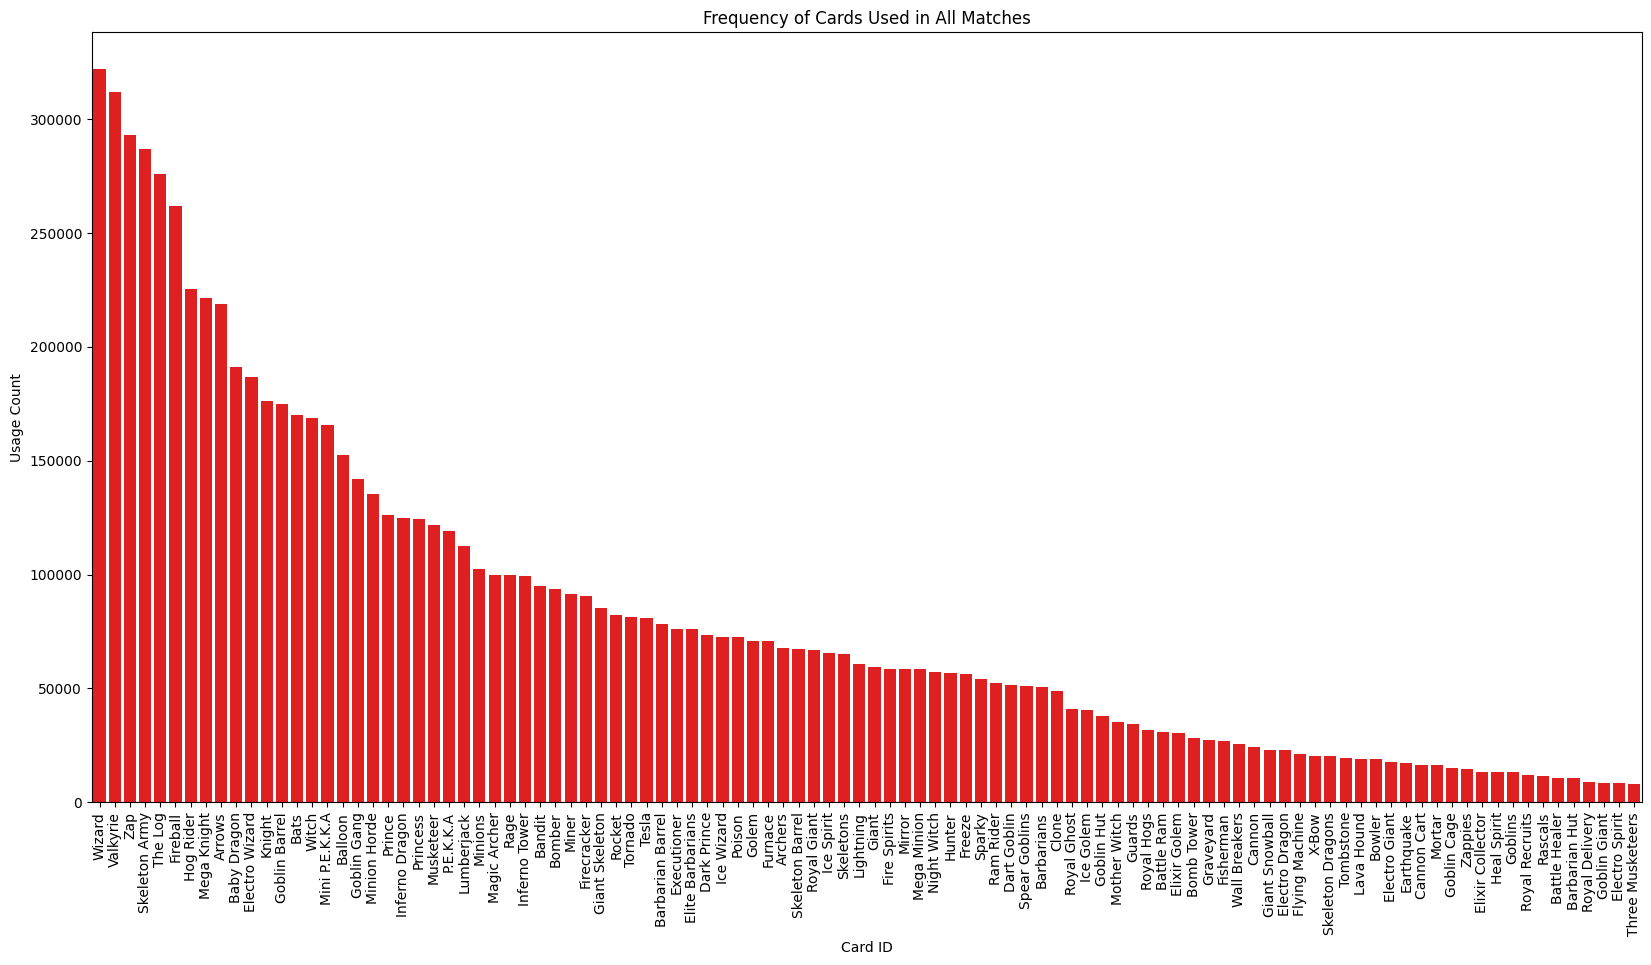

In [21]:
# Bar Plot of Cards used the most
all_cards = df[card_cols].values.flatten()
card_counts = pd.Series(all_cards).value_counts()


plt.figure(figsize=(20, 10))
sns.barplot(x=card_counts.index, y=card_counts.values, color='red')
plt.title("Frequency of Cards Used in All Matches")
plt.xlabel("Card ID")
plt.ylabel("Usage Count")
plt.xticks(rotation=90)
plt.show()

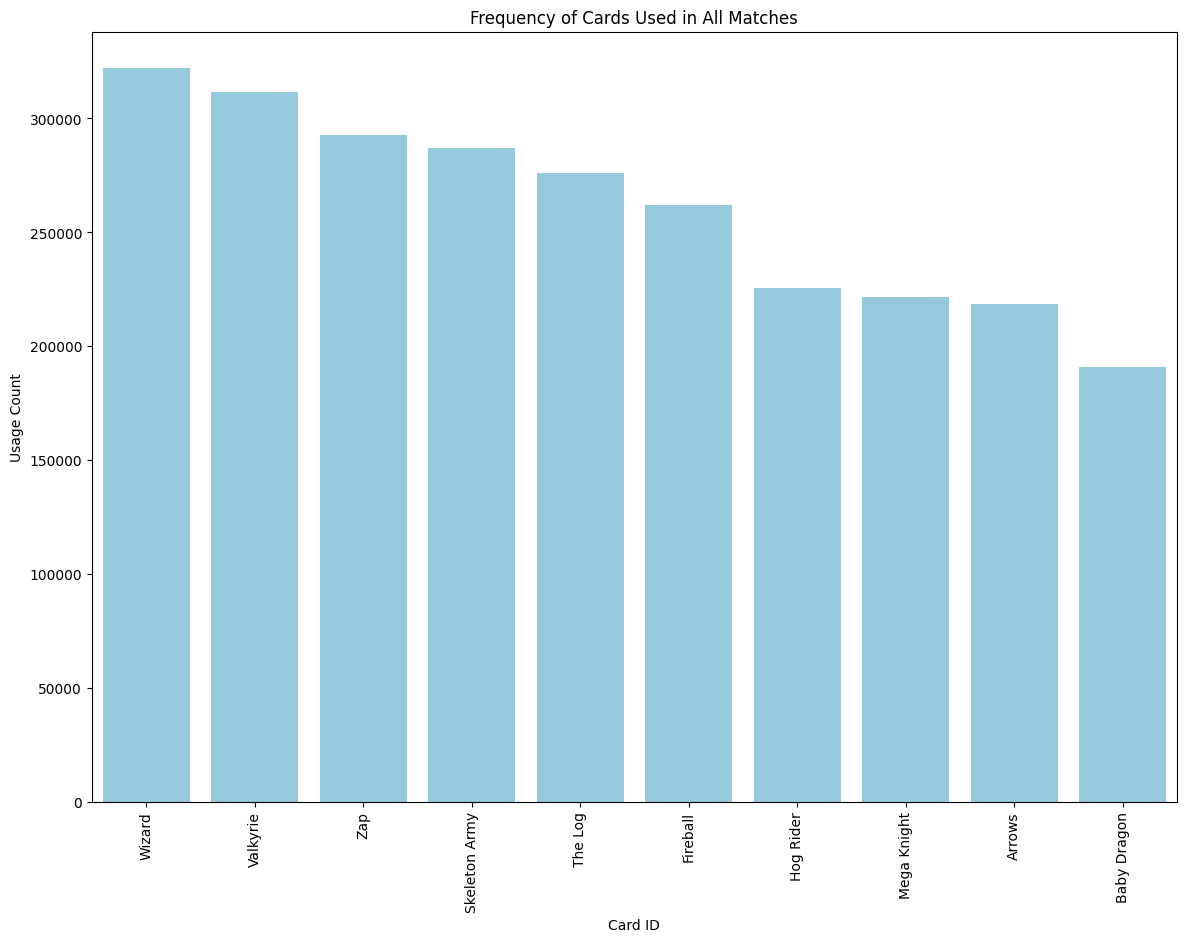

In [19]:
# Show the ten most used cards
top10 = card_counts.head(10)

plt.figure(figsize=(14, 10))
sns.barplot(x=top10.index, y=top10.values, color='skyblue')
plt.title("Frequency of Cards Used in All Matches")
plt.xlabel("Card ID")
plt.ylabel("Usage Count")
plt.xticks(rotation=90)
plt.show()

In [22]:
# Bar plot of card levels
all_card_levels = df[[f'winner.card{i}.level' for i in range(1, 9)] + [f'loser.card{i}.level' for i in range(1, 9)]].values.flatten()
card_level_counts = pd.Series(all_cards).value_counts()

plt.figure(figsize=(14, 10))
sns.barplot(x=card_level_counts, y=all_card_levels)
plt.title('Distribution of Card Levels')
plt.ylabel('Card Level')
plt.show()

ValueError: array length 8401984 does not match index length 102

<Figure size 1400x1000 with 0 Axes>

In [ ]:
# Box plot of Winner Elixir Average vs Loser Elixir Average
plt.figure(figsize=(14, 10))
sns.boxplot(data=df[['winner.elixir.average', 'loser.elixir.average']])
plt.title("Elixir Average Distribution (Winner vs Loser)")
plt.ylabel("Elixir Average")
plt.show()

# Shows that elixir average alone doesn't determine match outcomes

<h2><strong>Data Prep for Model Building</strong></h2>

<h5>Create Baseline DataFrames Which Will Be Used To Create Main DataFrame</h5>

In [ ]:
# Create 2 dataframes, one with winning decks, another with losing decks and their outcomes

win_df = df[['winner.card1.id', 'winner.card1.level', 'winner.card2.id', 'winner.card2.level', 'winner.card3.id', 
             'winner.card3.level', 'winner.card4.id', 'winner.card4.level', 'winner.card5.id', 'winner.card5.level', 
             'winner.card6.id', 'winner.card6.level', 'winner.card7.id', 'winner.card7.level', 'winner.card8.id', 
             'winner.card8.level', 'winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 
             'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 
             'winner.elixir.average']].copy()
win_df['target'] = 1

lose_df = df[['loser.card1.id', 'loser.card1.level', 'loser.card2.id', 'loser.card2.level', 'loser.card3.id',
              'loser.card3.level', 'loser.card4.id', 'loser.card4.level', 'loser.card5.id', 'loser.card5.level', 
              'loser.card6.id', 'loser.card6.level', 'loser.card7.id', 'loser.card7.level', 'loser.card8.id', 
              'loser.card8.level', 'loser.totalcard.level', 'loser.troop.count', 'loser.structure.count', 
              'loser.spell.count', 'loser.common.count', 'loser.rare.count', 'loser.epic.count', 'loser.legendary.count', 
              'loser.elixir.average']].copy()
lose_df['target'] = 0


In [ ]:
# Transform win_df so that each column is each and every card in the dataset and will either have a value of 0 or its level depending on if the card is in that deck

win_card_cols = [f'winner.card{i}.id' for i in range(1, 9)]
win_card_levels = [f'winner.card{i}.level' for i in range(1, 9)]

win_cards_long = pd.DataFrame({
    'deck': win_df.index.repeat(8),
    'card_id': win_df[win_card_cols].values.flatten(),
    'card_level': win_df[win_card_levels].values.flatten(),
    'target': win_df['target'].repeat(8)
})

win_cards_long = win_cards_long.pivot_table(
    index = 'deck',
    columns = 'card_id',
    values = 'card_level',
    fill_value = 0
)

win_numeric_cols = win_df[['winner.totalcard.level', 'winner.troop.count', 'winner.structure.count', 
             'winner.spell.count', 'winner.common.count', 'winner.rare.count', 'winner.epic.count', 'winner.legendary.count', 
             'winner.elixir.average']].reset_index(drop=True)

win_numeric_cols = win_numeric_cols.rename(columns={
    'winner.totalcard.level': 'totalcard_level',
    'winner.troop.count': 'troop_count',
    'winner.structure.count': 'structure_count',
    'winner.spell.count': 'spell_count',
    'winner.common.count': 'common_count',
    'winner.rare.count': 'rare_count',
    'winner.epic.count': 'epic_count',
    'winner.legendary.count': 'legendary_count',
    'winner.elixir.average': 'elixir_average'
})


final_win_df = pd.concat([win_numeric_cols, win_cards_long.reset_index(drop=True)], axis=1)
final_win_df['target'] = win_df['target'].values

print(final_win_df.head())
print(final_win_df.shape)


In [ ]:
# Transform lose_df so that each column is each and every card in the dataset and will either have a value of 0 or its level depending on if the card is in that deck

lose_card_cols = [f'loser.card{i}.id' for i in range(1, 9)]
lose_card_levels = [f'loser.card{i}.level' for i in range(1, 9)]


lose_cards_long = pd.DataFrame({
    'deck': lose_df.index.repeat(8),
    'card_id': lose_df[lose_card_cols].values.flatten(),
    'card_level': lose_df[lose_card_levels].values.flatten(),
    'target': lose_df['target'].repeat(8)
})

lose_cards_long = lose_cards_long.pivot_table(
    index = 'deck',
    columns = 'card_id',
    values = 'card_level',
    fill_value = 0
)

lose_numeric_cols = lose_df[['loser.totalcard.level', 'loser.troop.count', 'loser.structure.count', 
              'loser.spell.count', 'loser.common.count', 'loser.rare.count', 'loser.epic.count', 'loser.legendary.count', 
              'loser.elixir.average']].reset_index(drop=True)

lose_numeric_cols = lose_numeric_cols.rename(columns={
    'loser.totalcard.level': 'totalcard_level',
    'loser.troop.count': 'troop_count',
    'loser.structure.count': 'structure_count',
    'loser.spell.count': 'spell_count',
    'loser.common.count': 'common_count',
    'loser.rare.count': 'rare_count',
    'loser.epic.count': 'epic_count',
    'loser.legendary.count': 'legendary_count',
    'loser.elixir.average': 'elixir_average'
})


final_lose_df = pd.concat([lose_numeric_cols, lose_cards_long.reset_index(drop=True)], axis=1)
final_lose_df['target'] = lose_df['target'].values


print(final_lose_df.head())
print(final_lose_df.shape)

<h5><strong>Creating a new dataframe which includes winning and losing cards from each match on the same row and which deck won (1 or 0)</strong></h5>

In [ ]:
# Combine both lose and win df onto axis 1
final_win_df.pop('target')
final_lose_df.pop('target')

final_win_df = final_win_df.add_prefix('deckA.')
final_lose_df = final_lose_df.add_prefix('deckB.')

X = pd.concat([final_win_df, final_lose_df], axis=1).reset_index(drop=True)
X['target'] = 1.0

print(X.head())

In [ ]:
# 50% of rows will be swapped
swap = np.random.rand(len(X)) < 0.5

# Columns for each deck
winner_cols = [col for col in X.columns if col.startswith('deckA.')]
loser_cols = [col for col in X.columns if col.startswith('deckB.')]

# Swap decks where swap is True
X_swap = X[swap].copy()
X_swap[winner_cols], X_swap[loser_cols] = X_swap[loser_cols].values, X_swap[winner_cols].values

# Flip outcome for swapped rows
X_swap['target'] = 1 - X_swap['target']

# Replace original rows with swapped ones
X.loc[swap] = X_swap
y = X.pop('target')

print(X.head())
print(X.shape)

<h5>Scale Dataset</h5>

In [ ]:
# Scale Data
scaler = StandardScaler()
cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X))

X.columns = cols
print(X.head())
print(X.shape)


<h5>Delete Unused DataFrames to Save Memory</h5>

In [ ]:
del win_card_cols, win_cards_long, win_numeric_cols, win_df, final_win_df, lose_card_cols, lose_cards_long, lose_numeric_cols, lose_df, final_lose_df
gc.collect() 

<h5><strong>Train Test Split</strong></h5>

In [ ]:
# Perform an 80/20 split on the second dataset (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

<h2><strong>Model Building</strong></h2>

<h5><strong>Predicting overall win rate of deck A vs deck B</strong></h5>

<h5>Neural Network</h5>

In [ ]:
# Define all needed functions/methods

Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Model = tf.keras.models.Model
Sequential = tf.keras.Sequential

In [ ]:
# Define Neural Network Model

num_features = X_train.shape[1]

nn_model = Sequential([
    Dense(256, input_dim=num_features, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

print(nn_model.summary())

In [ ]:
# Train neural network with our data

epochs = 30

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model_history = nn_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=epochs, batch_size=512, verbose=1)

In [ ]:
# Graph Training and Validation accuracy and loss

acc = nn_model_history.history['accuracy']
val_acc = nn_model_history.history['val_accuracy']

loss = nn_model_history.history['loss']
val_loss = nn_model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h2><strong>User Functions to Predict Win Rate</strong></h2>

<h5>Elixir Average Function</h5>

In [ ]:
# Get Elixr Average Function
def getElixrAvg(deck):
    total = 0

    elixirCost = {
    # Troops
    "Knight": 3,
    "Archers": 3,
    "Goblins": 2,
    "Giant": 5,
    "P.E.K.K.A": 7,
    "Minions": 3,
    "Balloon": 5,
    "Witch": 5,
    "Barbarians": 5,
    "Golem": 8,
    "Skeletons": 1,
    "Valkyrie": 4,
    "Skeleton Army": 3,
    "Bomber": 2,
    "Musketeer": 4,
    "Baby Dragon": 4,
    "Prince": 5,
    "Wizard": 5,
    "Mini P.E.K.K.A": 4,
    "Spear Goblins": 2,
    "Giant Skeleton": 6,
    "Hog Rider": 4,
    "Minion Horde": 5,
    "Ice Wizard": 3,
    "Royal Giant": 6,
    "Guards": 3,
    "Princess": 3,
    "Dark Prince": 4,
    "Three Musketeers": 9,
    "Lava Hound": 7,
    "Ice Spirit": 1,
    "Fire Spirits": 2,
    "Miner": 3,
    "Sparky": 6,
    "Bowler": 5,
    "Lumberjack": 4,
    "Battle Ram": 4,
    "Inferno Dragon": 4,
    "Ice Golem": 2,
    "Mega Minion": 3,
    "Dart Goblin": 3,
    "Goblin Gang": 3,
    "Electro Wizard": 4,
    "Elite Barbarians": 6,
    "Hunter": 4,
    "Executioner": 5,
    "Bandit": 3,
    "Royal Recruits": 7,
    "Night Witch": 4,
    "Bats": 2,
    "Royal Ghost": 3,
    "Ram Rider": 5,
    "Zappies": 4,
    "Rascals": 5,
    "Cannon Cart": 5,
    "Mega Knight": 7,
    "Skeleton Barrel": 3,
    "Flying Machine": 4,
    "Wall Breakers": 2,
    "Royal Hogs": 4,
    "Goblin Giant": 6,
    "Fisherman": 3,
    "Magic Archer": 4,
    "Electro Dragon": 5,
    "Firecracker": 3,
    "Elixir Golem": 3,
    "Battle Healer": 4,
    "Skeleton Dragons": 4,
    "Mother Witch": 4,
    "Electro Spirit": 1,
    "Electro Giant": 8,

    # Buildings
    "Cannon": 3,
    "Goblin Hut": 5,
    "Mortar": 4,
    "Inferno Tower": 5,
    "Bomb Tower": 4,
    "Barbarian Hut": 7,
    "Tesla": 4,
    "Elixir Collector": 6,
    "X-Bow": 6,
    "Tombstone": 3,
    "Furnace": 4,
    "Goblin Cage": 4,

    # Spells
    "Fireball": 4,
    "Arrows": 3,
    "Rage": 2,
    "Rocket": 6,
    "Goblin Barrel": 3,
    "Freeze": 4,
    "Mirror": 1,
    "Lightning": 6,
    "Zap": 2,
    "Poison": 4,
    "Graveyard": 5,
    "The Log": 2,
    "Tornado": 3,
    "Clone": 3,
    "Earthquake": 3,
    "Barbarian Barrel": 2,
    "Heal Spirit": 1,
    "Giant Snowball": 2,
    "Royal Delivery": 3
    }

    # Add to total elixir based on card name
    for card in deck:
        if card in elixirCost.keys():
            total += elixirCost[card]
    
    return round((total / 8), 1)

<h5><strong>Predict Win Rate of One Deck Against Another</strong></h5>

<h5>Neural Network Model</h5>

In [ ]:
# Predict Win Rate of Deck A compared to Deck B Function (be user inputted values or pre determined)

def predictWinDeck(deckA_cards=[], deckA_levels=[], descA_values=[], deckB_cards=[], deckB_levels=[], descB_values=[], model=nn_model, scaler=scaler, feature_columns=X.columns):
    # Define a new dataframe with the feature columns
    deck_df = pd.DataFrame(columns=feature_columns)
    deck_df.loc[0] = 0.0

    # Define description values for deck A and B
    desc = ['troop_count', 'structure_count', 'spell_count', 'common_count', 'rare_count', 'epic_count', 'legendary_count']
    descA = ['deckA.' + desc for desc in desc]
    descB = ['deckB.' + desc for desc in desc]

    # User input if there are no parameters or not all parameters are filled out
    if deckA_cards == [] or deckA_levels == [] or descA_values == [] or deckB_cards == [] or deckB_levels == [] or descB_values == []:
        deckA_cards = []
        deckA_levels = []
        descA_values = []
        deckB_cards = []
        deckB_levels = []
        descB_values = []
        
        # Get cards and levels via user input for deck A
        for i in range(8):
            if i == 0:
                card = input('Enter the name of the first card in deck A: ')
            else:
                card = input('Enter the name of the next card in deck A: ')
            level = input('Enter the level of that card: ')
            deckA_cards.append('deckA.' + card)
            deckA_levels.append(float(level))
        
        # Get description values via user input for deck A
        for i in range(7):
            value = input(f'What is the {desc[i]} of deck A: ')
            descA_values.append(float(value))

        # Get cards and levels via user input for deck B
        for i in range(8):
            if i == 0:
                card = input('Enter the name of the first card in deck B: ')
            else:
                card = input('Enter the name of the next card in deck B: ')
            level = input('Enter the level of that card: ')
            deckB_cards.append('deckB.' + card)
            deckB_levels.append(float(level))
        
        # Get description values via user input for deck B
        for i in range(7):
            value = input(f'What is the {desc[i]} of deck B: ')
            descB_values.append(float(value))

    # Append average elixir average to deck A and B descriptions
    deck_df.loc[0, 'deckA.elixir_average'] = getElixrAvg(deckA_cards)
    deck_df.loc[0, 'deckB.elixir_average'] = getElixrAvg(deckB_cards)

    # Get total level and add it to dataframe
    deck_df.loc[0, 'deckA.totalcard_level'] = sum(deckA_levels)
    deck_df.loc[0, 'deckB.totalcard_level'] = sum(deckB_levels)

    # Format cards to match feature names
    deckA_cards = ['deckA.' + card for card in deckA_cards]
    deckB_cards = ['deckB.' + card for card in deckB_cards]

    # Add all values to dataset
    for card, level in zip(deckA_cards, deckA_levels):
        if card in deck_df.columns:
            deck_df.loc[0, card] = level

    for desc, value in zip(descA, descA_values):
        if desc in deck_df.columns:
            deck_df.loc[0, desc] = value
    
    for card, level in zip(deckB_cards, deckB_levels):
        if card in deck_df.columns:
            deck_df.loc[0, card] = level

    for desc, value in zip(descB, descB_values):
        if desc in deck_df.columns:
            deck_df.loc[0, desc] = value

    # Scale dataset
    deck_df = pd.DataFrame(scaler.transform(deck_df))
    deck_df.columns = feature_columns

    # Predict win rate using dataset
    win_rate = model.predict(deck_df)[0][0]
    
    # return round(float(win_rate), 4)
    return win_rate

In [ ]:
# Example Usage

cardsA = ['Hog Rider', 'Skeletons', 'Fireball', 'Cannon', 'Ice Spirit', 'Musketeer', 'Ice Golem', 'The Log']
levelsA = [13, 13, 13, 13, 13, 13, 13, 13]
desc_valuesA = [5, 1, 2, 3, 4, 0, 1]

cardsB = ['Graveyard', 'Baby Dragon', 'Fireball', 'Knight', 'Ice Spirit', 'Musketeer', 'Goblin Gang', 'Tesla']
levelsB = [1, 1, 1, 1, 1, 1, 1, 1]
desc_valuesB = [6, 1, 1, 4, 2, 1, 1]

win_rate = predictWinDeck(cardsA, levelsA, desc_valuesA, cardsB, levelsB, desc_valuesB)
# win_rate = predictWinDeck() # For User Input

print(f'Predicted win probability of Deck A against Deck B (Neural Network): {win_rate}')